## project

In [1]:
import pandas as pd
from math import floor
import numpy as np
from pathlib import Path
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, array_to_img
from matplotlib import pyplot as plt

In [2]:
train_path =Path('dataset/train')
test_path =Path('dataset/test')
val_path = Path('dataset/validation')

In [5]:
image_count = (len(list(train_path.glob('*/*.*'))) + 
               len(list(test_path.glob('*/*.*'))) +
               len(list(val_path.glob('*/*.*'))))
print(image_count)

2283


In [7]:
len(list(train_path.glob('*/*.*'))),len(list(test_path.glob('*/*.*'))),len(list(val_path.glob('*/*.*')))

(1597, 343, 343)

In [8]:
batch_size = 64
img_height = 128
img_width = 128

In [9]:
train_ds = image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale",
  shuffle=True)

Found 1597 files belonging to 2 classes.


In [10]:
train_ds.class_names

['NORMAL', 'TURBERCULOSIS']

In [11]:
test_ds = image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 343 files belonging to 2 classes.


In [12]:
val_ds = image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 343 files belonging to 2 classes.


In [13]:
class_names = train_ds.class_names
class_names

['NORMAL', 'TURBERCULOSIS']

In [14]:
num_classes = len(class_names)
num_classes

2

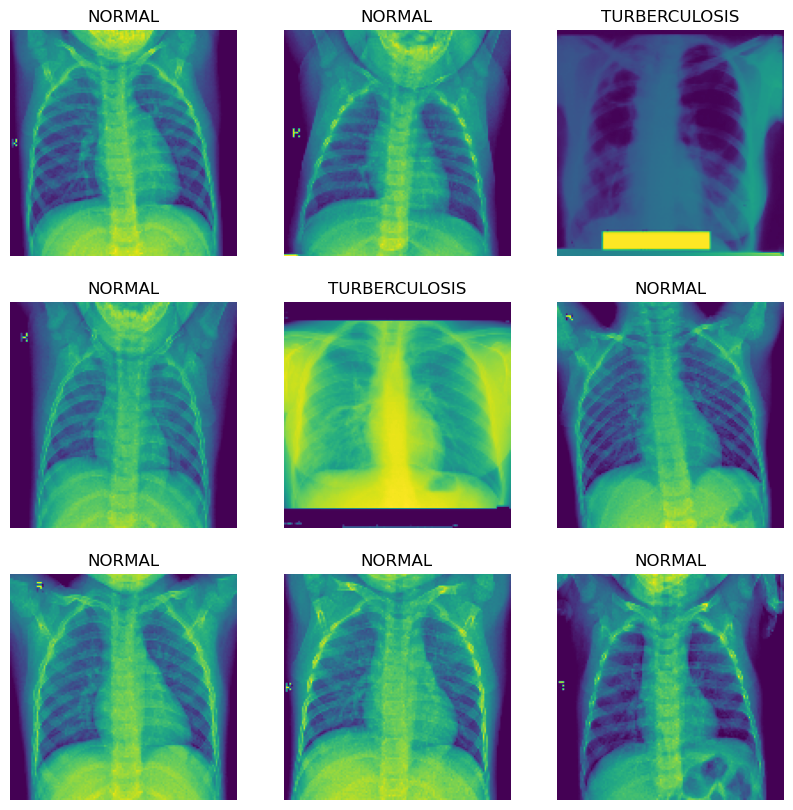

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
class_labels_train = np.concatenate([y for x, y in train_ds], axis=0)
class_labels_train, len(class_labels_train)

(array([1, 1, 0, ..., 0, 0, 0]), 1597)

In [18]:
class_labels = np.unique(class_labels_train)
class_labels

array([0, 1])

In [19]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=class_labels, 
                                                  y=class_labels_train)
class_weights

array([0.72066787, 1.63292434])

In [20]:
class_weights_dict = {}

for idx, i in enumerate(class_weights):
    class_weights_dict[idx] = i

    
print(class_weights_dict)

{0: 0.7206678700361011, 1: 1.6329243353783232}


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Reshape,MaxPooling2D, Flatten, BatchNormalization, Resizing, Rescaling, Lambda, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
model = Sequential()
model.add(Input(shape=(None, None, 1)))

model.add(Resizing(128, 128))
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), activation='relu',))
model.add(MaxPooling2D(4,4))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

In [25]:
checkpoint = ModelCheckpoint(filepath="Tuberculosis.keras",
                             monitor='val_loss', save_best_only=True,
                             save_weights_only=False,
                             verbose=3)

earlystopper = EarlyStopping(monitor='val_loss', patience=4)

callbackslist = [checkpoint, earlystopper]

In [26]:
model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=callbackslist, class_weight=class_weights_dict)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6763 - Accuracy: 0.6036
Epoch 1: val_loss improved from inf to 0.51991, saving model to Tuberculosis.keras
25/25 [==============================] - 8s 252ms/step - loss: 0.6763 - Accuracy: 0.6036 - val_loss: 0.5199 - val_Accuracy: 0.8717
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.3184 - Accuracy: 0.8973
Epoch 2: val_loss improved from 0.51991 to 0.08918, saving model to Tuberculosis.keras
25/25 [==============================] - 5s 188ms/step - loss: 0.3184 - Accuracy: 0.8973 - val_loss: 0.0892 - val_Accuracy: 0.9650
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.1084 - Accuracy: 0.9631
Epoch 3: val_loss improved from 0.08918 to 0.05320, saving model to Tuberculosis.keras
25/25 [==============================] - 5s 190ms/step - loss: 0.1084 - Accuracy: 0.9631 - val_loss: 0.0532 - val_Accuracy: 0.9825
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 

In [27]:
train_loss, train_acc = model.evaluate(train_ds, verbose = 0)
test_loss, test_acc = model.evaluate(test_ds, verbose = 0)
val_loss, val_acc = model.evaluate(val_ds, verbose = 0)

In [28]:
print("Training Accuracy: %5.2f\nTraining Loss: %5.2f \n"%(train_acc*100, train_loss))
print("Testing Accuracy: %5.2f \nTesting Loss: %5.2f \n"%(test_acc*100, test_loss))
print("Val Accuracy: %5.2f \nVal Loss: %5.2f"%(val_acc*100, val_loss))

Training Accuracy: 100.00
Training Loss:  0.00 

Testing Accuracy: 99.42 
Testing Loss:  0.03 

Val Accuracy: 99.42 
Val Loss:  0.03


In [43]:
model.save("tuberculosis.keras")

In [30]:
# import tensorflow as tf
# tf.keras.models.save_model(model, "BrainTumorsModels.keras")

In [31]:
loaded_model = tf.keras.models.load_model("Pneumonia.keras")

In [32]:
true_y = np.concatenate([y for x, y in val_ds])
true_y, len(true_y)

(array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 

In [33]:
preds_softmax = loaded_model.predict(val_ds)

6/6 [==============================] - 0s 33ms/step


In [34]:
preds = []
for i in preds_softmax:
    preds.append(np.argmax(i))
#del(preds_softmax)
len(preds)

343

In [35]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, cohen_kappa_score,f1_score, confusion_matrix

In [36]:
print("Accuracy Score is ",accuracy_score(true_y, preds))
print("Recall Score is ",recall_score(true_y, preds, average='macro'))
print("Precision Score is ",precision_score(true_y, preds, average='macro'))
print("Cohen Kappa Score is ",cohen_kappa_score(true_y, preds))
print("F1 Score is ",f1_score(true_y, preds, average='macro'))
print("Confusion Matrix is \n",confusion_matrix(true_y, preds))

Accuracy Score is  0.9941690962099126
Recall Score is  0.9904761904761905
Precision Score is  0.9958333333333333
Cohen Kappa Score is  0.9862010701210927
F1 Score is  0.9931002574831027
Confusion Matrix is 
 [[238   0]
 [  2 103]]


We need to apply the same preprocessing techniques we used for the training data to any new image.
Here are the steps to processing new images.
* Resize the image to be of 128x128 dimensions. 
* Convert the image to grayscale.
* Expand image dimensions to take the following form, (batch_size, img_height, img_width, num_channels)

In [37]:
def prediction(image):
    image = image.convert("L")
    image = (np.expand_dims(image,0))
    predictions = loaded_model.predict(image, verbose=0)
    pred=np.argmax(predictions)
    return pred

In [40]:
def prediction_decode(image):
    image = image.convert("L")
    image = (np.expand_dims(image,0))
    predictions = loaded_model.predict(image, verbose=0)
    pred=np.argmax(predictions)
    return class_names[pred]

In [41]:
from PIL import Image
img=Image.open("dataset/validation/TURBERCULOSIS/Tuberculosis-5.png")
prediction(img), prediction_decode(img)

(1, 'TURBERCULOSIS')

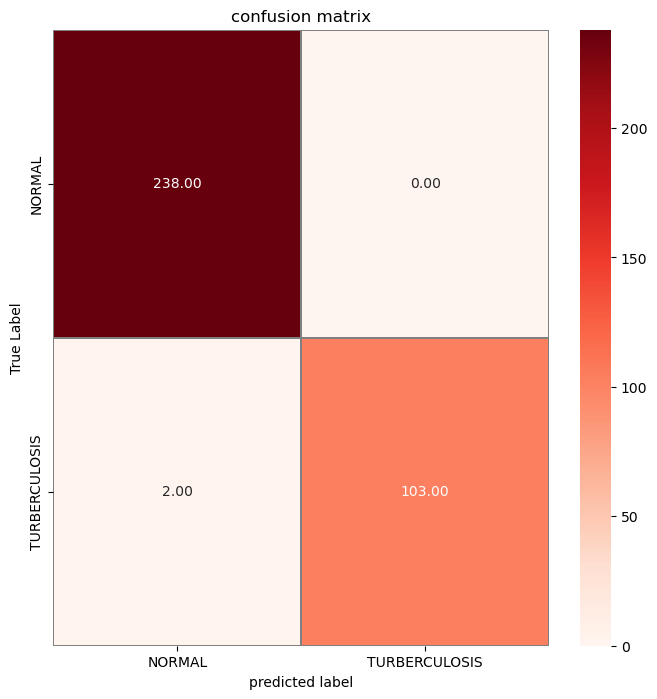

In [42]:
confusion_mtx = confusion_matrix(true_y, preds)
target_names = class_names
plt.figure(figsize = (8,8))
sns.heatmap(confusion_mtx,cmap= "Reds", linecolor = 'gray' , linewidth = 0.01 , annot = True, fmt='.2f' , xticklabels = target_names , yticklabels = target_names)
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()